<a href="https://colab.research.google.com/github/paulzelina/Thesis_experimental/blob/main/Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scilpy

In [ ]:
import scilpy


In [ ]:
import nibabel as nib
import numpy as np
#np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
from dipy.io.streamline import load_tractogram
from dipy.reconst.dti import fractional_anisotropy
from dipy.tracking.streamline import set_number_of_points
from scipy.spatial import distance
from scipy.spatial.distance import euclidean
#import centroid_scil_qb as cs
#import centroid_new as csn
import dipy.stats.analysis as dsa
import dipy.tracking.streamline as dts
from dipy.io.image import load_nifti
from scilpy.tractanalysis.features import get_streamlines_centroid

In [ ]:
fa_map, affine = load_nifti("/100206__fa.nii.gz")
fa = nib.load("/100206__fa.nii.gz")
#fa_data = fa_map.get_fdata()

# Load the tractography data
bundles_filename = "/ATR_left.tck"
#bundles_filename2 = "Data/AF_right.tck"
streams = load_tractogram(bundles_filename, fa).streamlines
#streams2 = load_tractogram(bundles_filename2, fa).streamlines

# Number of points to resample each streamline
num_points = 40

# Resample all streamlines to an equal number of segments/points
#resampled_streams = [set_number_of_points(streamline, num_points) for streamline in streams]

# Compute centroids using the first method
centroid_method1 = np.array(get_streamlines_centroid(streams, num_points))


In [ ]:
# Orient the streamlines using the first method
#oriented_af_l1 = dts.orient_by_streamline(streams, centroid_method1[0])
# Calculate the weights for the first method
# w_af_l = dsa.gaussian_weights(oriented_af_l1)
# Calculate the profile using the oriented streamlines and corresponding weights for each method
#profile_af_l1 = dsa.afq_profile(fa_map, oriented_af_l1, affine, 100, orient_by=centroid_method1[0], weights=w_af_l)
#print(profile_af_l1)

In [ ]:
from dipy.tracking.utils import length
from dipy.tracking.streamline import Streamlines

def generate_core_streamline(streamlines, percentage, distance_threshold, nb_points=40):
    # Step 1: Averaging the top percentage longest streamlines
    num_streamlines = len(streamlines)

    num_longest = int(percentage / 100 * num_streamlines)

    #return top_5_percent_streamlines
    lengths = list(length(streamlines))
    lengths_pts = [length(streamline) for streamline in streamlines]
    threshold = (np.percentile(lengths, 100-percentage))
    long_streamlines = Streamlines()
    for i, sl in enumerate(streamlines):
        if lengths[i] > threshold:
            long_streamlines.append(sl)

    core_streamline = get_streamlines_centroid(long_streamlines, nb_points)
    return core_streamline

In [ ]:
#centroid_method2 = np.array(generate_core_streamline(streams, 1, 5, num_points))
# Orient the streamlines using the first method
#oriented_af_l2 = dts.orient_by_streamline(streams, centroid_method2[0])
# Calculate the weights for the first method
#w_af_l2 = dsa.gaussian_weights(oriented_af_l2)
# Calculate the profile using the oriented streamlines and corresponding weights for each method
#profile_af_l2 = dsa.afq_profile(fa_map, oriented_af_l2, affine, 100, orient_by=centroid_method2[0], weights=w_af_l2)
#print(profile_af_l2)

In [ ]:
print(affine)

[[  -1.25    0.      0.     77.5 ]
 [   0.      1.25    0.   -113.5 ]
 [   0.      0.      1.25  -63.25]
 [   0.      0.      0.      1.  ]]


In [ ]:
def resample_streamlines_num_points(sft, num_points):
    """
    Resample streamlines using number of points per streamline

    Parameters
    ----------
    sft: StatefulTractogram
        SFT containing the streamlines to subsample.
    num_points: int
        Number of points per streamline in the output.

    Return
    ------
    resampled_sft: StatefulTractogram
        The resampled streamlines as a sft.
    """

    # Checks
    if num_points <= 1:
        raise ValueError("The value of num_points should be greater than 1!")

    # Resampling
    lines = set_number_of_points(sft, num_points)

    # Creating sft
    # CAREFUL. Data_per_point will be lost.
    #resampled_sft = _warn_and_save(lines, sft)

    return lines

In [ ]:
#!pip install --upgrade dipy

In [ ]:
#from dipy.align.streamlinear import StreamlineLinearRegistration
from dipy.tracking.streamlinespeed import (length, set_number_of_points)
from dipy.io.stateful_tractogram import StatefulTractogram
from nibabel.streamlines import ArraySequence
from scilpy.utils.streamlines import uniformize_bundle_sft
from scilpy.tractanalysis.distance_to_centroid import min_dist_to_centroid

centroid_method1 = resample_streamlines_num_points(get_streamlines_centroid(streams, num_points), num_points)
streams = resample_streamlines_num_points(streams, num_points)
#srr = StreamlineLinearRegistration()
#srm = srr.optimize(static=streams,
                           #moving=centroid_method1)
#centroid_method1 = srm.transform(centroid_method1)
centroid_method1 = ArraySequence(centroid_method1)
#centroid_method1_seq = StatefulTractogram.from_sft(centroid_method1, np.eye(4))
#uniformize_bundle_sft(streams, ref_bundle=centroid_method1[0])

#dists, labels = min_dist_to_centroid(streams._data, centroid_method1._data)
#print(dists)
#print("and")
#print(labels)

In [ ]:
#from dipy.reconst.interpolate import approx_gradient
from dipy.tracking.streamline import values_from_volume

def fa_profiling(centroid, streams):
  #centroid = np.array(centroid)
  #centroid = np.array(centroid).reshape(num_points, 3)
  centroid = ArraySequence(centroid)
  print("Shape of centroid._data:", centroid._data.shape)
  print("Shape of streams._data:", streams._data.shape)
  dists, labels = min_dist_to_centroid(streams._data, centroid._data)
  print("Shape of dists:", dists.shape)
  print("Shape of labels:", labels.shape)
  fa_values = values_from_volume(fa_map, streams, affine)
  #print("Shape of fa_values:", fa_values.shape)

  # Initialize an empty list to hold the FA values for each centroid point
  fa_values_centroid = [[] for _ in range(num_points)]

  # Assign the FA values to the corresponding centroid point
  for fa_value, dist in zip(fa_values, dists):
      fa_values_centroid[dist].append(fa_value)

  # Calculate the average FA value for each centroid point
  fa_values_avg = [np.nan if not values else np.mean(values) for values in fa_values_centroid]
  return fa_values_avg
  print("FA values at each point on the centroid:", fa_values_avg)


In [ ]:
from itertools import count, takewhile
import logging
from multiprocessing import Pool

from dipy.segment.clustering import QuickBundles, qbx_and_merge
from dipy.segment.featurespeed import ResampleFeature
from dipy.segment.metric import AveragePointwiseEuclideanMetric
from dipy.tracking import metrics as tm
import numpy as np

def get_streamlines_centroid(streamlines, nb_points):
    """
    Compute centroid from streamlines using QuickBundles.

    Parameters
    ----------
    streamlines: list of ndarray
        The list of streamlines from which we compute the centroid.
    nb_points: int
        Number of points defining the centroid streamline.

    Returns
    -------
    List of length one, containing a np.ndarray of shape (nb_points, 3)
    """
    resample_feature = ResampleFeature(nb_points=nb_points)
    quick_bundle = QuickBundles(
        threshold=np.inf,
        metric=AveragePointwiseEuclideanMetric(resample_feature))
    clusters = quick_bundle.cluster(streamlines)
    centroid_streamlines = clusters.centroids

    print(type(centroid_streamlines))
    return centroid_streamlines

In [ ]:
def generate_core_streamline(streamlines, percentage=5, nb_points=40):
    # Step 1: Averaging the top percentage longest streamlines
    num_streamlines = len(streamlines)

    num_longest = int(percentage / 100 * num_streamlines)

    #return top_5_percent_streamlines
    lengths = list(length(streamlines))
    lengths_pts = [length(streamline) for streamline in streamlines]
    threshold = (np.percentile(lengths, 100-percentage))
    long_streamlines = Streamlines()
    for i, sl in enumerate(streamlines):
        if lengths[i] > threshold:
            long_streamlines.append(sl)

    core_streamline = get_streamlines_centroid(long_streamlines, nb_points = 40)
    return core_streamline

In [ ]:
from scipy.interpolate import splprep, splev
import numpy as np
from scipy.spatial import ConvexHull
from scipy.interpolate import BSpline
from dipy.tracking.utils import length
from dipy.tracking.streamline import Streamlines
#import centroid_scil_qb as cs
from sklearn.cluster import KMeans


def generate_core_streamline_new1(streamlines, percentage = 5, distance_threshold = 20, nb_points = 40):
    # Step 1: Averaging the top percentage longest streamlines
    num_streamlines = len(streamlines)

    num_longest = int(percentage / 100 * num_streamlines)

    lengths = list(length(streamlines))
    lengths_pts = [length(streamline) for streamline in streamlines]
    threshold1 = (np.percentile(lengths, 100-percentage))
    long_streamlines = Streamlines()
    for i, sl in enumerate(streamlines):
        if lengths[i] > threshold1:
            long_streamlines.append(sl)

    core_streamline = get_streamlines_centroid(long_streamlines, nb_points)

    # Step 2: Generating orthogonal planes and finding intersecting points
    core_streamline_array = core_streamline[0]  # Extract the NumPy array from the list
    all_centers_of_mass = []
    all_points_initial_core = []
    all_normals = []
    c=0
    min_area = 10000
    all_points = []
    all_areas = []
    #print(len(core_streamline_array))
    for i in range(len(core_streamline_array) - 1):
        segment = core_streamline_array[i:i+2]

        if len(segment) != 2:
            continue

        direction_vector = segment[1] - segment[0]
        tangent_vector = direction_vector / np.linalg.norm(direction_vector)

        # Compute a normal vector
        normal_vector = tangent_vector
        # Define the plane through the point segment[0] and normal to normal_vector
        plane_point = segment[0]  # Any point on the plane
        plane_normal = normal_vector  # The normal vector to the plane

        # Find intersection points of the plane with the rest of the streamlines
        intersection_points = []
        for streamline in streamlines:
            for j in range(len(streamline) - 1):
                line_point = streamline[j]  # Any point on the line
                line_vector = streamline[j+1] - streamline[j]  # The direction vector of the line

                # Solve for the intersection point
                t = np.dot(plane_normal, plane_point - line_point) / np.dot(plane_normal, line_vector)
                intersection_point = line_point + t * line_vector

                # Check if the intersection point lies within the line segment
                if 0 <= t <= 1:
                    distance = np.linalg.norm(intersection_point - segment[0])
                # Check if the distance is less than the threshold
                    if distance < distance_threshold:
                        intersection_points.append(intersection_point)
        #return intersection_points

        c=c+1
        #print("counter", c)
        #print("intersection sets sizes: ", len(intersecting_points))
        #return intersecting_points
        if c%4==1:
            #print("c: ", c)
            all_points.extend(list(intersection_points))
        if intersection_points:
            #closest_points = np.array(intersecting_points)
            #print("Shape of closest_points:", closest_points.shape)

            # Ensure that closest_points has at least two dimensions
            #if closest_points.ndim >= 2:
            hull = ConvexHull(intersection_points)
            area = hull.area
            #print("Area is: ", area)
            all_areas.append(area)

            # Check if the current hull area is smaller than min_area
            if i < 2 and i > nb_points - 1:
                if area < min_area:
                    min_area = area

                # Step 4: Compute the center of mass for each hull
                #print("Shape of hull_2d.vertices:", hull_2d.vertices.shape)
                #print("Sample vertices:", hull_2d.vertices[:5])  # Print the first 5 vertices for inspection
                #return hull
                #return (hull.points)
            #center_of_mass = np.mean(intersection_points, axis=0)
            #center_of_mass = np.mean(hull.points, axis=0)
        #print("center of mass example: ", center_of_mass)
            #all_centers_of_mass.append(center_of_mass)
                #return center_of_mass
                #all_centers_of_mass = [np.array(center) for center in all_centers_of_mass]
                #all_centers_of_mass = np.array(all_centers_of_mass)
            #else:
                #print("Error: closest_points should have at least two dimensions.")

        # Step 5: Linking centers of mass with a B-spline curve

    # After computing all hull areas, iterate again to perform clustering
    for i in range(len(core_streamline_array) - 1):
        segment = core_streamline_array[i:i+2]

        if len(segment) != 2:
            continue

        direction_vector = segment[1] - segment[0]
        tangent_vector = direction_vector / np.linalg.norm(direction_vector)

        # Compute a normal vector
        normal_vector = tangent_vector
        # Define the plane through the point segment[0] and normal to normal_vector
        plane_point = segment[0]  # Any point on the plane
        plane_normal = normal_vector  # The normal vector to the plane

        # Find intersection points of the plane with the rest of the streamlines
        intersection_points = []
        for streamline in streamlines:
            for j in range(len(streamline) - 1):
                line_point = streamline[j]  # Any point on the line
                line_vector = streamline[j+1] - streamline[j]  # The direction vector of the line

                # Solve for the intersection point
                t = np.dot(plane_normal, plane_point - line_point) / np.dot(plane_normal, line_vector)
                intersection_point = line_point + t * line_vector

                # Check if the intersection point lies within the line segment
                if 0 <= t <= 1:
                    distance = np.linalg.norm(intersection_point - segment[0])
                # Check if the distance is less than the threshold
                    if distance < distance_threshold:
                        intersection_points.append(intersection_point)

        #print(len(intersection_points))
        if intersection_points:
            hull = ConvexHull(intersection_points)
            area = hull.area

            # Check if the current hull area is more than 2 times the min_area
            center_of_mass = np.mean(intersection_points, axis=0)
            all_centers_of_mass.append(center_of_mass)

    #all_centers_of_mass_np = np.array(all_centers_of_mass)
    #if len(all_centers_of_mass_np) > k:
        # Create a periodic closure of the points
        #closed_points = np.vstack((all_centers_of_mass_np, all_centers_of_mass_np[0]))

        # Create a B-spline representation of the closed points
        #tck, u = splprep(all_centers_of_mass_np.T, s=0)

        # Evaluate the B-spline representation at a fine grid of points
        #new_points = splev(np.linspace(0, 1, 100), tck)
    #else:
        #print(f"Number of centers of mass ({len(all_centers_of_mass_np)}) is less than or equal to k ({k}).")

    segment = core_streamline_array[nb_points-2:nb_points]

    direction_vector = segment[1] - segment[0]
    tangent_vector = direction_vector / np.linalg.norm(direction_vector)

    # Compute a normal vector
    normal_vector = tangent_vector
    # Define the plane through the point segment[0] and normal to normal_vector
    plane_point = segment[1]  # Any point on the plane
    plane_normal = normal_vector  # The normal vector to the plane

    # Find intersection points of the plane with the rest of the streamlines
    intersection_points = []
    for streamline in streamlines:
        for j in range(len(streamline) - 1):
             line_point = streamline[j]  # Any point on the line
             line_vector = streamline[j+1] - streamline[j]  # The direction vector of the line

             # Solve for the intersection point
             t = np.dot(plane_normal, plane_point - line_point) / np.dot(plane_normal, line_vector)
             intersection_point = line_point + t * line_vector
             # Check if the intersection point lies within the line segment
             if 0 <= t <= 1:
                distance = np.linalg.norm(intersection_point - segment[1])
             # Check if the distance is less than the threshold
                if distance < distance_threshold:
                    intersection_points.append(intersection_point)

    #print(len(intersection_points))
    if intersection_points:
        hull = ConvexHull(intersection_points)
        area = hull.area

        # Check if the current hull area is more than 2 times the min_area
        center_of_mass = np.mean(intersection_points, axis=0)
        all_centers_of_mass.append(center_of_mass)


    #print((all_centers_of_mass))
    #all_centers_of_mass = np.array(all_centers_of_mass).reshape(nb_points, 3)
    all_centers_of_mass = [np.array(all_centers_of_mass).reshape(-1, 3)]
    print(type(all_centers_of_mass))
    return (all_centers_of_mass)

In [ ]:
fa_profile1 = fa_profiling(get_streamlines_centroid(streams, 40), streams)

<class 'list'>
Shape of centroid._data: (40, 3)
Shape of streams._data: (80000, 3)
Shape of dists: (80000,)
Shape of labels: (80000,)


In [ ]:
#get_streamlines_centroid(streams, 40)

In [ ]:
fa_profile2 = fa_profiling(generate_core_streamline(streams, 40), streams)

<class 'list'>
Shape of centroid._data: (40, 3)
Shape of streams._data: (80000, 3)
Shape of dists: (80000,)
Shape of labels: (80000,)


In [ ]:
fa_profile3 = fa_profiling(generate_core_streamline_new1(streams, percentage=5, distance_threshold = 20, nb_points=40), streams)

<class 'list'>
<class 'list'>
Shape of centroid._data: (40, 3)
Shape of streams._data: (80000, 3)
Shape of dists: (80000,)
Shape of labels: (80000,)


In [ ]:
import matplotlib.pyplot as plt

def plot_fa_profiles(fa_profiles):
    colors = ['r', 'g', 'b']  # colors for the FA profiles

    for i, fa_profile in enumerate(fa_profiles):
        plt.plot(fa_profile, color=colors[i], label=f'Centroid {i+1}')

    plt.xlabel('Point along centroid')
    plt.ylabel('FA value')
    plt.legend()
    plt.show()

In [ ]:
print(fa_profile1)

[0.3839377467203702, 0.3929443207794494, 0.387373122330474, 0.3864743772864162, 0.38095639935579817, 0.39154826339045967, 0.3868880476542837, 0.3839172055731231, 0.37747033139576075, 0.39336296452947717, 0.37427747927245497, 0.3902131312381343, 0.40008810836386033, 0.3882128053756915, 0.3928063224140347, 0.3893864613478485, 0.39301004780022725, 0.3972639738044801, 0.38831998139232127, 0.39242569945344763, 0.3744802592969629, 0.3910826137029289, 0.3998397662266553, 0.3870246447981504, 0.38908399055593096, 0.37968432388045453, 0.39306966061494625, 0.37229040960500925, 0.3799614024066516, 0.38721258775805806, 0.38660575527097735, 0.39733334097429024, 0.39020162716293627, 0.376233554664459, 0.38542128501251527, 0.39564894668717, 0.3787179946691913, 0.3955124861354996, 0.3809263614358577, 0.38664361551107346]


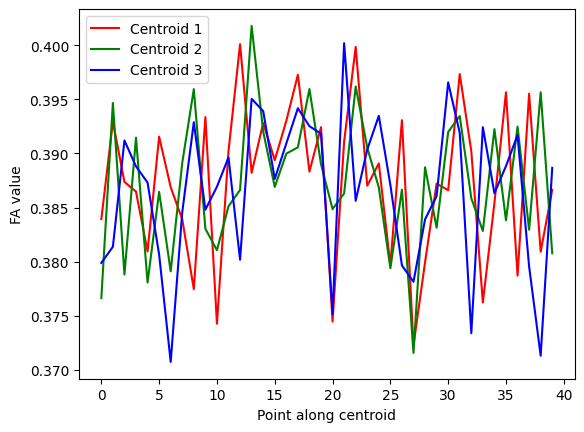

In [ ]:
plot_fa_profiles([fa_profile1, fa_profile2, fa_profile3])